## PROBLEM STATEMENT
Create a Recommender System for **Zee** to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

### My Views:
 - Giving personalized and relevant movie recommendations to the users is a very important task for **Zee** to increase engagement and user experience.
 - Better engagement would mean people would be spending more time on **Zee's** platform, through which people would develop an affinity for **Zee**
 - Existing users would renew their subscriptions and as a reult Churn would reduce, which would also impact Revenue.
 - If the experience is good, more people would be interested to take **Zee** subscription, which can directly increase revenue.
 - Better do No recommendation than doing a wrong recommendation.

## Data Dictionary:


### 1) RATINGS FILE DESCRIPTION


All ratings are contained in the file "ratings.dat" and are in the following format: **UserID::MovieID::Rating::Timestamp**

- UserIDs range between 1 and 6040
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds
- Each user has at least 20 ratings

### 2) USERS FILE DESCRIPTION

User information is in the file "users.dat" and is in the following format: **UserID::Gender::Age::Occupation::Zip-code**

All demographic information is provided voluntarily by the users and is not checked for accuracy.
Only users who have provided some demographic information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges: 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+"

- Occupation is chosen from the following choices: 0: "other" or not specified, 1: "academic/educator", 2: "artist", 3: "clerical/admin", 4: "college/grad student", 5: "customer service", 6: "doctor/health care", 7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer", 12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed", 17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer"

### 3) MOVIES FILE DESCRIPTION

Movie information is in the file "movies.dat" and is in the following format: **MovieID::Title::Genres**

- Titles are identical to titles provided by the IMDB (including year of release)

- Genres are pipe-separated and are selected from the following genres: Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from cmfrec import CMF

### Movies Dataset

In [2]:
movies=pd.read_fwf('zee-movies.dat',encoding='ISO-8859-1')
movies=pd.DataFrame(data=(movies['Movie ID::Title::Genres'].str.split('::')).tolist(),columns=movies.columns[0].split('::'))
movies.rename(columns={'Movie ID':'MovieID'},inplace=True)
display(movies.head())

print('Shape:',movies.shape) # There are 3833 rows.

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Shape: (3883, 3)


In [3]:
# Checking for missing values.
print(movies.isna().sum())
# There are 25 movies for which Genre is not present. We can remove these movies.

# Making a copy of the original dataset.
movies_original=movies.copy()

# Removing the movies which has "Genre" missing.
movies_to_remove=list(movies.loc[movies['Genres'].isna(),'MovieID']) 
movies=movies[~movies['MovieID'].isin(movies_to_remove)].reset_index(drop=True)

MovieID     0
Title       0
Genres     25
dtype: int64


In [4]:
# Getting Release Year for every movie and removing year from Title.
movies['Release_Year']=movies['Title'].apply(lambda x : x[-5:-1])

# Lets check if there are any wrong values for "Release_Year".
print(movies['Release_Year'].unique()) # Everything seems okay.

['1995' '1994' '1996' '1976' '1993' '1992' '1988' '1967' '1977' '1965'
 '1982' '1962' '1990' '1991' '1989' '1937' '1940' '1969' '1981' '1973'
 '1970' '1960' '1955' '1956' '1959' '1968' '1980' '1975' '1986' '1948'
 '1943' '1950' '1946' '1987' '1997' '1974' '1958' '1949' '1972' '1998'
 '1933' '1952' '1951' '1957' '1961' '1954' '1934' '1944' '1963' '1942'
 '1941' '1964' '1953' '1939' '1947' '1945' '1938' '1935' '1936' '1926'
 '1932' '1930' '1971' '1979' '1966' '1978' '1985' '1983' '1984' '1931'
 '1922' '1927' '1929' '1928' '1925' '1923' '1999' '1919' '2000' '1920'
 '1921']


In [5]:
# Removing year from Title for every movie.
movies['Title']=movies['Title'].apply(lambda x : x[:-7])

In [6]:
#Checking Movies Dataset Information
print(movies.info())

# Changing 'MoviedID' and "Release_Year" columns to integer datatype.
movies[['MovieID','Release_Year']]=movies[['MovieID','Release_Year']].astype('int')
movies_original[['MovieID']]=movies_original[['MovieID']].astype('int')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MovieID       3858 non-null   object
 1   Title         3858 non-null   object
 2   Genres        3858 non-null   object
 3   Release_Year  3858 non-null   object
dtypes: object(4)
memory usage: 120.7+ KB
None


In [7]:
# Exploding the Dataset.
movies_exploded=movies.copy()
movies_exploded['Genres']=movies_exploded['Genres'].str.split('|')
movies_exploded=movies_exploded.explode(column='Genres')
display(movies_exploded.head(5))

,MovieID,Title,Genres,Release_Year
0,1,Toy Story,Animation,1995
0,1,Toy Story,Children's,1995
0,1,Toy Story,Comedy,1995
1,2,Jumanji,Adventure,1995
1,2,Jumanji,Children's,1995


In [8]:
print('Movies Shape:',movies.shape)
print('Exploded_Movies Shape:',movies_exploded.shape)

Movies Shape: (3858, 4)
Exploded_Movies Shape: (6341, 4)


In [9]:
# Checking for number of unique movies.
print('Unique Movies:',movies['MovieID'].nunique())

# Checking for number of unique Genres.
print('Unique Genres:',movies_exploded['Genres'].nunique())
print()

# From the information provided earlier, we know that there are 18 Genres only, which are:
# Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical" 
# "Mystery, Romance, Sci-Fi, Thriller, War, Western".
# But from the dataset provided, there are 63 unique Genres. We need to inspect further.

# Checking the unique categories of Genre.
movies_exploded['Genres'].unique()

Unique Movies: 3858
Unique Genres: 63



array(['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir',
       'Dram', 'Western', 'Chil', '', 'Fantas', 'Dr', 'D', 'Documenta',
       'Wester', 'Fant', 'Music', 'Childre', 'Childr', 'Rom', 'Animati',
       'Children', 'Come', "Children'", 'Sci-F', 'Adv', 'Adventu',
       'Horro', 'Docu', 'S', 'Sci-', 'Document', 'Th', 'Roman', 'Documen',
       'We', 'F', 'Ro', 'R', 'Sci', 'Chi', 'Thri', 'Adventur', 'Advent',
       'Acti', 'Roma', 'A', 'Comed', 'Com', 'Thrille', 'Wa', 'Horr'],
      dtype=object)

In [10]:
# Observation 1 - There is a Genre which is an empty string. We can therefore remove these movies.
movies=movies.loc[~(movies['Genres']=='')]
movies_exploded=movies_exploded.loc[~(movies_exploded['Genres']=='')]


# Observation2 - There are a lot of Genres which have spelling variations. We need to correct the mistyped names.
def function(x):
    if x in ['A','Acti','Action']:
        return 'Action'
    if x in ['Adv','Advent','Adventu','Adventur','Adventure']:
        return "Adventure"
    if x in ['Animati','Animation']:
        return "Animation"
    if x in ['Chi','Chil','Childr','Childre','Children',"Children'","Children's"]:
        return "Childrens"
    if x in ['Com','Come','Comed','Comedy']:
        return "Comedy"
    if x in ['Crime']:
        return "Crime"
    if x in ['D','Docu','Documen','Document','Documenta','Documentary'] :
        return "Documentary"
    if x in ['Dr','Dram','Drama']:
        return "Drama"
    if x in ['F','Fant','Fantas','Fantasy']:
        return "Fantasy"
    if x in ['Film-Noir']:
        return "Film_Noir"
    if x in ['Horr','Horro','Horror']:
        return "Horror"
    if x in ['Musical','Music']:
        return "Musical"
    if x in ['Mystery']:
        return "Mystery"
    if x in ['R','Ro','Rom','Roma','Roman','Romance']:
        return "Romance"
    if x in ['S','Sci','Sci-','Sci-F','Sci-Fi']:
        return "Sci_Fi"
    if x in ['Th','Thri','Thrille','Thriller']:
        return "Thriller"
    if x in ['Wa','War']:
        return "War"
    if x in ["We",'Wester','Western']:
        return "Western"
   
movies_exploded['Genres']=movies_exploded['Genres'].apply(function)

In [11]:
# Removing duplicate entries if there are any.
print(movies_exploded.duplicated().sum()) # There is 1 entry which is duplicate.

# Removing the duplicate entry.
movies_exploded=movies_exploded[~movies_exploded.duplicated()]

1


In [12]:
# Final Look at the Dataset.
movies_exploded.head()

,MovieID,Title,Genres,Release_Year
0,1,Toy Story,Animation,1995
0,1,Toy Story,Childrens,1995
0,1,Toy Story,Comedy,1995
1,2,Jumanji,Adventure,1995
1,2,Jumanji,Childrens,1995


In [13]:
# Checking for number of unique movies.
print('Unique Movies:',movies_exploded['MovieID'].nunique())

# Checking for number of unique Genres.
print('Unique Genres:',movies_exploded['Genres'].nunique())

# Checking for number of Release Years.
print('Unique Release Years:',movies_exploded['Release_Year'].nunique())

# Checking the shape of the dataset.
print('Exploded Movies Dataset Shape:',movies_exploded.shape)
print()

# Checking Exploded_Movies Info.
display(movies_exploded.info())

Unique Movies: 3856
Unique Genres: 18
Unique Release Years: 81
Exploded Movies Dataset Shape: (6332, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6332 entries, 0 to 3857
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MovieID       6332 non-null   int32 
 1   Title         6332 non-null   object
 2   Genres        6332 non-null   object
 3   Release_Year  6332 non-null   int32 
dtypes: int32(2), object(2)
memory usage: 197.9+ KB


None

In [14]:
movies_pivot=movies_exploded.pivot(index='MovieID',columns='Genres',values='Title')
movies_pivot=(~movies_pivot.isna()).astype('int')
movies_pivot.head()

Genres,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Users Dataset

In [15]:
users=pd.read_fwf('zee-users.dat',encoding='ISO-8859-1')
users=pd.DataFrame(data=users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::').tolist(),columns=users.columns[0].split('::'))
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [16]:
# Checking for missing values.
print(users.isna().sum())
print()
# There are no missing values in users dataset.

# Checking the shape of the dataset.
print('Users Shape',users.shape)

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

Users Shape (6040, 5)


In [17]:
# Checking the information of the users dataset.
display(users.info())

# Changing data type of the variables.
users[['UserID', 'Age', 'Occupation']]=users[['UserID', 'Age', 'Occupation']].astype('int')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


None

In [18]:
# Checking number of unique categories in different variables.
print('Users:',users['UserID'].nunique())
print('Gender:',users['Gender'].nunique())
print('Age:',users['Age'].nunique())
print('Occupation:',users['Occupation'].nunique())
print('Zip Code:',users['Zip-code'].nunique())

Users: 6040
Gender: 2
Age: 7
Occupation: 21
Zip Code: 3439


In [19]:
# Encoding Gender variable.
users['Gender']=users['Gender'].map({'F':0,'M':1})

### Ratings Dataset

In [20]:
ratings=pd.read_fwf('zee-ratings.dat',encoding='ISO-8859-1')
ratings=pd.DataFrame(data=ratings['UserID::MovieID::Rating::Timestamp'].str.split('::').tolist(),columns=ratings.columns[0].split('::'))
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [21]:
# Checking the information of Ratings Dataset.
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [22]:
# Changing the data type of all the variable to 'int'.
ratings=ratings.astype('int')

In [23]:
# Extracting Hour from Timestamp variable.
ratings['Hour']=ratings['Timestamp'].apply(lambda x : datetime.fromtimestamp(x).hour)

In [24]:
# Checking for missing values.
print(ratings.isna().sum())
print()
# There are no missing values in users dataset.

# Checking the shape of the dataset.
print('Ratings Shape',ratings.shape)

UserID       0
MovieID      0
Rating       0
Timestamp    0
Hour         0
dtype: int64

Ratings Shape (1000209, 5)


## EDA

#### Q1) Availability of Genres in Zee.

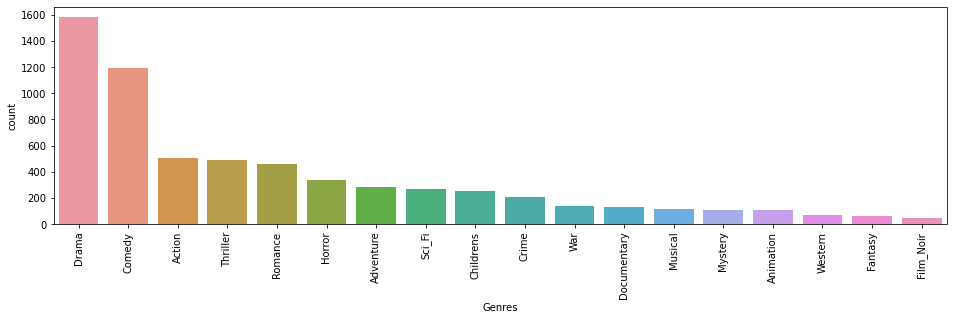

In [25]:
plt.figure(figsize=(16,4))
sns.countplot(data=movies_exploded,x='Genres',order=movies_exploded['Genres'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

In [26]:
# Top 5 occuring Genres.
display(np.round(movies_exploded['Genres'].value_counts(normalize=True)*100,2)[:5])

Drama       24.98
Comedy      18.78
Action       7.93
Thriller     7.71
Romance      7.30
Name: Genres, dtype: float64

In [27]:
# Bottom 5 occuring Genres.
display(np.round(movies_exploded['Genres'].value_counts(normalize=True)*100,2)[-5:])

Mystery      1.66
Animation    1.64
Western      1.07
Fantasy      0.99
Film_Noir    0.69
Name: Genres, dtype: float64

#### Q2) Few Recent Movies.

In [28]:
temp=movies[movies['Release_Year']==np.max(movies['Release_Year'])]
print('Max Release Year:'
      ,np.max(movies['Release_Year']))
print('Number of movies released in Year 2000:',len(temp))
print('Total Movies Released:',len(movies))
print('Few Recent Movies are:')
for i in range(5):
    print(str(i+1)+': ',temp.iloc[i,1])

Max Release Year: 2000
Number of movies released in Year 2000: 156
Total Movies Released: 3856
Few Recent Movies are:
1:  Supernova
2:  Down to You
3:  Isn't She Great?
4:  Scream 3
5:  Gun Shy


#### Q3) Distribution of Release Years of the movies.

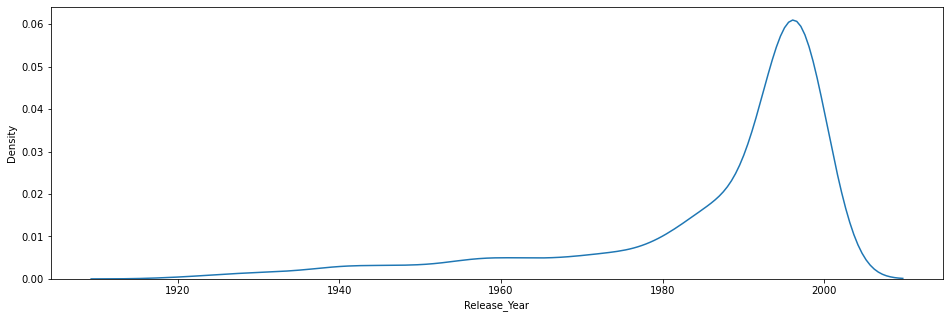

In [29]:
plt.figure(figsize=(16,5))
sns.kdeplot(movies['Release_Year'])
plt.show()

In [30]:
movies[['Release_Year']].describe().T

# Most movies are between Year 1980 and Year 2000.

,count,mean,std,min,25%,50%,75%,max
Release_Year,3856.0,1986.092324,16.900818,1919.0,1982.0,1994.0,1997.0,2000.0


#### Q4) Proportion of Male and Females.

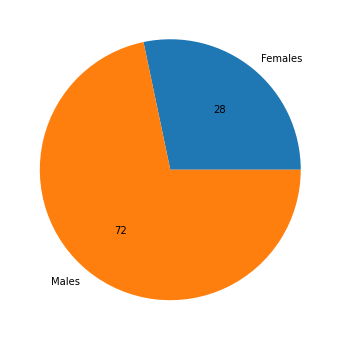

In [31]:
temp=users['Gender'].value_counts(normalize=True).sort_index().tolist()
plt.figure(figsize=(6,6))
plt.pie(temp,labels=['Females','Males'],autopct='%1.0f')
plt.show()

# Male:Female = 72:28

#### Q5) Distribution of Ages of the customers.

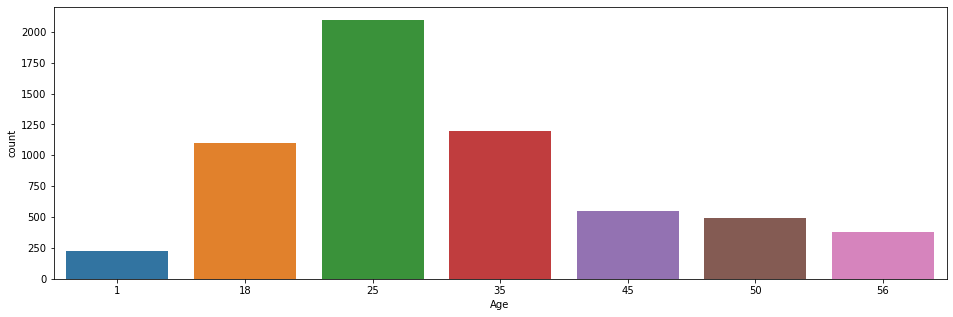

In [32]:
plt.figure(figsize=(16,5))
sns.countplot(data=users,x='Age')
plt.show()

In [33]:
display(np.round(users['Age'].value_counts(normalize=True)*100,2))

# Most people are between 18 and 44 years of Age.
# - 18: "18-24"
# - 25: "25-34"
# - 35: "35-44"

25    34.70
35    19.75
18    18.26
45     9.11
50     8.21
56     6.29
1      3.68
Name: Age, dtype: float64

#### Q6) Which are the occupations for which customers are available in Zee's platform?

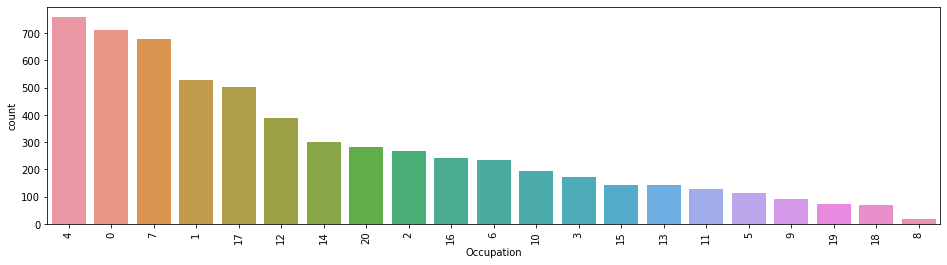

In [34]:
plt.figure(figsize=(16,4))
sns.countplot(data=users,x='Occupation',order=users['Occupation'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

In [35]:
# Top 5 occupations.
np.round(users['Occupation'].value_counts(normalize=True)*100)[:5]
# 4: "college/grad student"
# 0: "other" or not specified
# 7: "executive/managerial" 
# 1: "academic/educator"
# 17: "technician/engineer" 

4     13.0
0     12.0
7     11.0
1      9.0
17     8.0
Name: Occupation, dtype: float64

In [36]:
# Bottom 5 occupations.
np.round(users['Occupation'].value_counts(normalize=True)*100)[-5:]
# 5: "customer service"
# 9: "homemaker"
# 19: "unemployed" 
# 18: "tradesman/craftsman"
# 8: "farmer"

5     2.0
9     2.0
19    1.0
18    1.0
8     0.0
Name: Occupation, dtype: float64

#### Q7) Which Movies have the most number of ratings?

In [37]:
temp=ratings.groupby('MovieID').count()['Rating'].sort_values(ascending=False)[:10].index
print('Top 10 Movies that have the most number of ratings')
movies.loc[movies['MovieID'].isin(temp),'Title'].tolist()

Top 10 Movies that have the most number of ratings


['Star Wars: Episode IV - A New Hope',
 'Jurassic Park',
 'Terminator 2: Judgment Day',
 'Silence of the Lambs, The',
 'Star Wars: Episode V - The Empire Strikes Back',
 'Star Wars: Episode VI - Return of the Jedi',
 'Back to the Future',
 'Saving Private Ryan',
 'Matrix, The',
 'American Beauty']

#### Q8) Which Movies have the highest and lowest average ratings.
- Criteria: There should be atleast 50 ratings for the movie.

In [38]:
temp=ratings['MovieID'].value_counts()
temp=temp[temp>=50].index
top_5=ratings[ratings['MovieID'].isin(temp)].groupby(by='MovieID').mean()['Rating'].sort_values(ascending=False)[:5]
bottom_5=ratings[ratings['MovieID'].isin(temp)].groupby(by='MovieID').mean()['Rating'].sort_values(ascending=False)[-5:]

In [39]:
# Top 5 Movies with highest average Ratings.
print(movies.loc[movies['MovieID'].isin(top_5.index),'Title'].tolist()) 
# There are only 4 movies here. Seems like there is 1 movie which we removed earlier because of missing Genre.
# Lets get the names of all 5 movies from original movies dataset.

print()
print(movies_original.loc[movies_original['MovieID'].isin(top_5.index),'Title'].tolist()) 
# "'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (195'" is the movie which has missing Genre. Lets confirm.

display(movies_original[movies_original['Title']=='Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (195'])

['Shawshank Redemption, The', 'Close Shave, A', 'Godfather, The', 'Sanjuro']

['Shawshank Redemption, The (1994)', 'Close Shave, A (1995)', 'Godfather, The (1972)', 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (195', 'Sanjuro (1962)']


,MovieID,Title,Genres
1950,2019,Seven Samurai (The Magnificent Seven) (Shichin...,None


In [40]:
# Bottom 5 Movies with least average Ratings.
print(movies.loc[movies['MovieID'].isin(bottom_5.index),'Title'].tolist()) 

['Kazaam', 'Problem Child 2', 'Iron Eagle IV', 'Meatballs III', 'Battlefield Earth']


#### Q9) Distribution of Hour to understand the watching convenience time of the users.

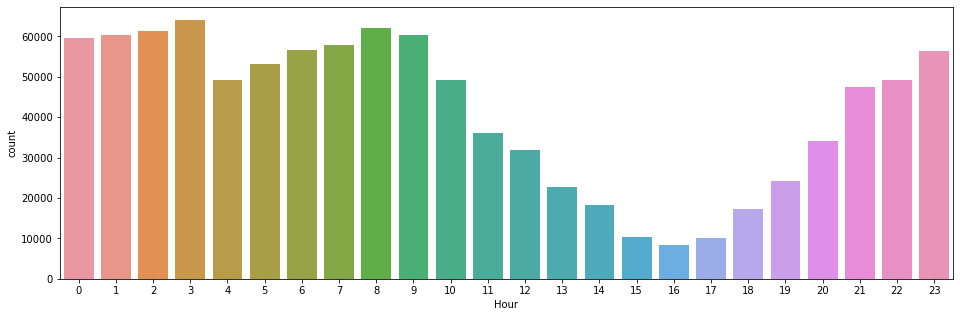

In [41]:
plt.figure(figsize=(16,5))
sns.countplot(data=ratings,x='Hour')
plt.show()

# Most users don't prefer watching between Hour 12 and Hour 20.

#### Q10) Distribution of Ratings

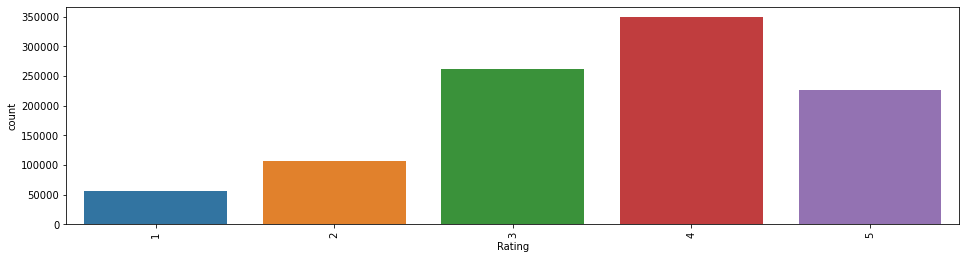

In [42]:
plt.figure(figsize=(16,4))
sns.countplot(data=ratings,x='Rating')
plt.xticks(rotation=90)
plt.show()

In [43]:
# Percentage wise distribution of Ratings.
np.round(ratings['Rating'].value_counts(normalize=True)*100)

# About 35 percent of the rated movies are "4". This is a good percentage.

4    35.0
3    26.0
5    23.0
2    11.0
1     6.0
Name: Rating, dtype: float64

#### Q11) Average Ratings of Different Genres?

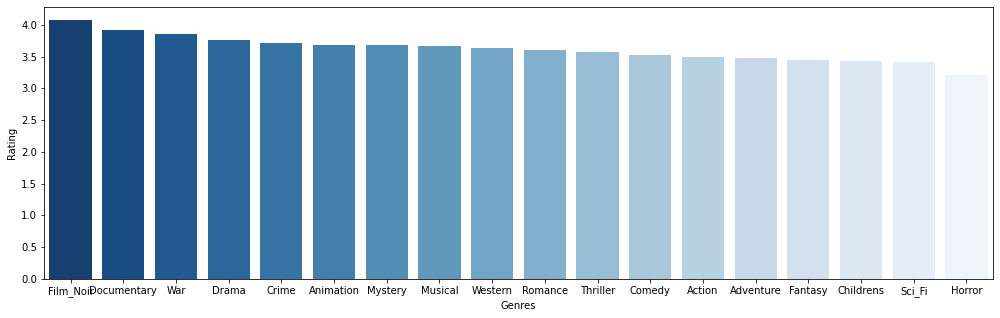

In [44]:
temp=pd.merge(left=ratings,right=movies_exploded,on='MovieID')
temp=temp.groupby(by='Genres')['Rating'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(17,5))
sns.barplot(data=temp,y='Rating',x='Genres',palette='Blues_r')
plt.show()

In [45]:
display(temp.T)

# "Film_Noir","Documentary" and "War" are the best rated Genres.
# "Childrens","Sci_Fi" and "Horror" are the worst rated Genres.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Genres,Film_Noir,Documentary,War,Drama,Crime,Animation,Mystery,Musical,Western,Romance,Thriller,Comedy,Action,Adventure,Fantasy,Childrens,Sci_Fi,Horror
Rating,4.075188,3.92111,3.857115,3.760356,3.708781,3.681149,3.67469,3.665105,3.63777,3.596233,3.568161,3.522711,3.48857,3.477666,3.453678,3.427365,3.412587,3.21645


#### Q12) Distribution of Ratings with Genders

<AxesSubplot:xlabel='Gender', ylabel='count'>

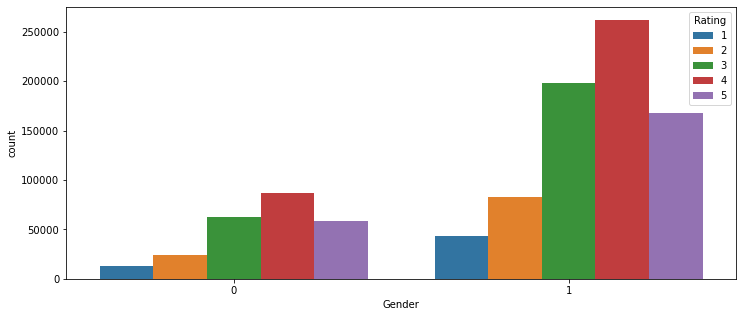

In [46]:
temp=pd.merge(left=ratings,right=users,on='UserID')
temp
plt.figure(figsize=(12,5))
sns.countplot(data=temp,hue='Rating',x='Gender')
# plt.show()

In [47]:
# Percentage wise distribution of Ratings Gender wise
np.round(pd.crosstab(temp['Gender'],temp['Rating'],normalize='index')*100,2)

# Seems like there isn't much difference between the distribution of ratings of Men and Women.

Rating,1,2,3,4,5
Gender,,,,,
0,5.42,9.96,25.55,35.32,23.76
1,5.68,11.01,26.30,34.75,22.26


# A) Item-Item Based Similarity.

## 1) Recommender System based on Pearson Correlation 

In [63]:
# Returns similar most movies.

def get_similar_movies(movies,similarity_matrix,movie_number):
    movie_name=movies.loc[movies['MovieID']==movie_number,'Title'].tolist()[0]
    similar_movies_order=similarity_matrix.loc[movie_number].sort_values(ascending=False)
    similar_movies_id=similar_movies_order.index.tolist()
    similar_movies_id.remove(movie_number)
    similar_movies_id=similar_movies_id[:10]
    similar_movies_df=pd.DataFrame(np.array([similar_movies_id,similar_movies_order.loc[similar_movies_id]])).T
    similar_movies_df.columns=['MovieID','Correlation']
    similar_movies_df=pd.merge(left=movies,right=similar_movies_df,on='MovieID')[['MovieID','Title','Correlation','Release_Year']]
    similar_movies_df=similar_movies_df.sort_values(by='Correlation')
    
    return movie_name,similar_movies_df

In [64]:
# Higher the Correlation Coefficient, higher the similarity.
movie_number=1
similarity_matrix=movies_pivot[:1000].T.corr()
item_item_recommendations=get_similar_movies(movies,similarity_matrix,movie_number)

print('Movie Name:',item_item_recommendations[0])
display('Recommendations:',item_item_recommendations[1])

Movie Name: Toy Story


'Recommendations:'

,MovieID,Title,Correlation,Release_Year
0,54,"Big Green, The",0.790569,1995
2,374,Richie Rich,0.790569,1994
3,586,Home Alone,0.790569,1990
5,596,Pinocchio,0.790569,1940
6,616,"Aristocats, The",0.790569,1970
7,709,Oliver & Company,0.790569,1988
8,837,Matilda,0.790569,1996
9,881,First Kid,0.790569,1996
1,239,"Goofy Movie, A",0.836660,1995
4,588,Aladdin,0.836660,1992


## 2) Recommender System based on Hamming Distance

In [55]:
# Returns similar most movies.

def get_similar_movies(movies,similarity_matrix,movie_number):
    movie_name=movies.loc[movies['MovieID']==movie_number,'Title'].tolist()[0]
    similar_movies_order=similarity_matrix.loc[movie_number].sort_values()
    similar_movies_id=similar_movies_order.index.tolist()
    similar_movies_id.remove(movie_number)
    similar_movies_id=similar_movies_id[:10]
    similar_movies_df=pd.DataFrame(np.array([similar_movies_id,similar_movies_order.loc[similar_movies_id]])).T
    similar_movies_df.columns=['MovieID','Distance']
    similar_movies_df=pd.merge(left=movies,right=similar_movies_df,on='MovieID')[['MovieID','Title','Distance','Release_Year']]
    similar_movies_df=similar_movies_df.sort_values(by='Distance')
    
    return movie_name,similar_movies_df

In [56]:
# Defining the Hamming_Distance Function to calculate similarity between movies.Lower the distance, higher is the similarity.
def hamming_distance_function(df):
    movie_ids=df.index
    df=df.values
    n=len(df)
    temp=[]
    for movie1 in df:
        arr=[]
        for movie2 in df:
            arr.append(np.sum(np.abs(movie1-movie2)))
        temp.append(arr)
    return pd.DataFrame(temp,index=movie_ids,columns=movie_ids)

In [57]:
# Finding similar movies.

movie_number=1
similarity_matrix=hamming_distance_function(movies_pivot.iloc[:1000])     
item_item_recommendations=get_similar_movies(movies,similarity_matrix,movie_number)

print('Movie Name:',item_item_recommendations[0])
display('Recommendations:',item_item_recommendations[1])

Movie Name: Toy Story


'Recommendations:'

,MovieID,Title,Distance,Release_Year
0,54,"Big Green, The",1,1995
1,244,Gumby: The Movie,1,1995
2,250,Heavyweights,1,1994
3,313,"Swan Princess, The",1,1994
4,355,"Flintstones, The",1,1994
5,374,Richie Rich,1,1994
6,575,"Little Rascals, The",1,1994
7,709,Oliver & Company,1,1988
8,801,Harriet the Spy,1,1996
9,837,Matilda,1,1996


In [58]:
# Preview of User User Similarity Matrix
similarity_matrix.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0,4,3,3,2,6,3,3,4,6,...,2,3,3,2,3,1,3,2,4,2
2,4,0,5,5,4,6,5,1,4,4,...,2,3,3,4,1,3,1,4,0,4
3,3,5,0,2,1,5,0,4,3,5,...,3,4,4,3,4,2,4,3,5,1
4,3,5,2,0,1,5,2,4,3,5,...,3,2,2,1,4,2,4,3,5,1
5,2,4,1,1,0,4,1,3,2,4,...,2,3,3,2,3,1,3,2,4,0


# B) User-User Based Similarity.

In [65]:
# Creating a merged users dataset to find similar users.
temp=ratings.groupby(by='UserID')[['Rating','Hour']].mean()
temp=pd.merge(left=temp,right=users,on='UserID')[['UserID','Rating','Hour','Gender','Age','Occupation']]


# Encoding age categories
mapper={1:1, 18:2, 25:3, 35:4, 45:5, 50:6, 56:7,}
temp['Age']=temp['Age'].map(mapper)
display(temp.head())

# One_Hot_Encoding "Occupation" variable.
encoder=OneHotEncoder(sparse=False,drop='first',dtype='int')
occupation_ohe_df=pd.DataFrame(data=encoder.fit_transform(temp[['Occupation']]),columns=encoder.get_feature_names_out())

# Dropping original "Occupation" variable
temp.drop(columns=['Occupation'],inplace=True)
temp=pd.concat((temp,occupation_ohe_df),axis=1)

# Scaling the "Rating", "Hour" and "Age".
scaler=StandardScaler()
scaled_columns=['Rating', 'Hour', 'Age']
remaining_columns=['UserID','Gender', 'Occupation_1', 'Occupation_2','Occupation_3', 'Occupation_4', 
                   'Occupation_5', 'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
                   'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14','Occupation_15', 'Occupation_16', 
                   'Occupation_17', 'Occupation_18', 'Occupation_19', 'Occupation_20']
temp_scaled=pd.DataFrame(data=scaler.fit_transform(temp[scaled_columns]),columns=scaled_columns)
users_df=pd.concat((temp_scaled,temp[remaining_columns]),axis=1)
users_df.index=users_df['UserID']
users_df.drop(columns=['UserID'],inplace=True)
display(users_df.head())

,UserID,Rating,Hour,Gender,Age,Occupation
0,1,4.188679,3.792453,0,1,10
1,2,3.713178,2.968992,1,7,16
2,3,3.901961,2.215686,1,3,15
3,4,4.190476,1.000000,1,5,7
4,5,3.146465,11.656566,1,3,20


,Rating,Hour,Age,Gender,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.131261,-0.909947,-1.747373,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.024380,-1.037952,2.251920,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.463832,-1.155052,-0.414276,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.135444,-1.344027,0.918822,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-1.294827,0.312509,-0.414276,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [66]:
# Returns similar most movies.

def get_similar_movies(movies_original,ratings,similarity_matrix,user_number):
    temp=similarity_matrix.loc[user_number]
    temp=temp.drop(index=user_number)
    most_closest_user=temp[temp==temp.min()].index.tolist()[0]
    
# Lets get the list of of movies which are rated highly by the most_closest_user.
    temp=ratings[ratings['UserID']==most_closest_user].sort_values(by='Rating',ascending=False).iloc[:10][['MovieID','Rating']]
    temp=pd.merge(left=temp,right=movies,on='MovieID')

    
    return user_number,most_closest_user,temp

## 2) Recommender System based on KNN Distance

In [67]:
# Defining the KNN_Distance Function to measure similarity between users. Lower the distance, higher is the similarity.
def knn_function(df):
    user_ids=df.index
    df=df.values
    n=len(df)
    temp=[]
    for user1 in df:
        arr=[]
        for user2 in df:
            arr.append(np.sum(user1-user2)**2)
        temp.append(arr)
    return pd.DataFrame(temp,index=user_ids,columns=user_ids)

In [68]:
user_number=1
similarity_matrix=knn_function(users_df.iloc[:1000])     

user_user_recommendations=get_similar_movies(movies_original,ratings,similarity_matrix,user_number)

print('User_Number:',user_user_recommendations[0])
print('Most_Closest_User:',user_user_recommendations[1])
display('Recommendations',user_user_recommendations[2])

User_Number: 1
Most_Closest_User: 978


'Recommendations'

,MovieID,Rating,Title,Genres,Release_Year
0,1199,5,Brazil,Sci-Fi,1985
1,1206,5,"Clockwork Orange, A",Sci-Fi,1971
2,1298,5,Pink Floyd - The Wall,Drama|Musical|War,1982
3,111,5,Taxi Driver,Drama|Thriller,1976
4,3160,5,Magnolia,Drama,1999
5,2329,5,American History X,Drama,1998
6,2318,5,Happiness,Comedy,1998
7,47,5,Seven (Se7en),Crime|Thriller,1995
8,1136,5,Monty Python and the Holy Grail,Comedy,1974
9,2712,5,Eyes Wide Shut,Drama,1999


## Recommender System based on Cosine Similarity

In [69]:
# Defining the Cosine Function to measure similarity between users. Lower the distance, higher is the similarity.
def cosine_function(df):
    user_ids=df.index
    df=df.values
    n=len(df)
    temp=[]
    for user1 in df:
        arr=[]
        for user2 in df:
            arr.append(np.dot(user1,user2)/(np.linalg.norm(user1)*np.linalg.norm(user2)))
        temp.append(arr)
    return pd.DataFrame(temp,index=user_ids,columns=user_ids)

In [70]:
user_number=1
similarity_matrix=cosine_function(users_df.iloc[:1000])     

user_user_recommendations=get_similar_movies(movies_original,ratings,similarity_matrix,user_number)

print('User_Number:',user_user_recommendations[0])
print('Most_Closest_User:',user_user_recommendations[1])
display('Recommendations',user_user_recommendations[2])

User_Number: 1
Most_Closest_User: 689


'Recommendations'

,MovieID,Rating,Title,Genres,Release_Year
0,249,5,Immortal Beloved,Drama|Romance,1994
1,2568,5,"Mod Squad, The",Action|Crime,1999
2,1253,5,"Day the Earth Stood Still, The",Drama|Sci-Fi,1951
3,2407,5,Cocoon,Comedy|Sci-Fi,1985
4,539,5,Sleepless in Seattle,Comedy|Romance,1993
5,924,5,2001: A Space Odyssey,Drama|Mystery|Sci-Fi|Thriller,1968
6,265,5,Like Water for Chocolate (Como agua para choco...,Drama|,1992
7,3528,5,"Prince of Tides, The",Drama|Romance,1991
8,2454,5,"Fly, The",Horror|Sci-Fi,1958


# C) Recommender System based on Matrix Factorization

In [ ]:
# ratings_df = ratings[['UserID', 'MovieID', 'Rating']].copy()
# ratings_df.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names

# model = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
# model.fit(rm_raw)

# Handling a Cold Start Problem 

#### For newly joined users, we wouldn't have all the User Information. This is a cold start problem. To handle this, we can ask for their favorite Genres. There are various ways we can recommend movies to new users. Some of them are:
- Recommend the most popular movies based on highest average Rating.
- Recommend the most recent movies.
- Recommend the movies which match with the new users's preferred Genres.
- Recommend the highest average rated movies on the basis of their location, i.e. Zip Code.